In [23]:
from __future__ import division

import einops
import random
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from PIL import ImageFilter


class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, crop_size=512):
        # MoCo v2's aug: similar to SimCLR https://arxiv.org/abs/2002.05709
        self.crop_size = crop_size
        self.random_resized_crop = CustomRandomResizedCrop(
            crop_size, scale=(0.5, 1.))
        self.random_horizontal_flip = CustomRandomHorizontalFlip()
        self.random_color_jitter = transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8)
        self.random_grayscale = transforms.RandomGrayscale(p=0.2)
        self.random_gaussian_blur = transforms.RandomApply(
            [GaussianBlur([.1, 2.])], p=0.5)
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    def _transform(self, x):
        x, (i, j, h, w) = self.random_resized_crop(x)
        x, hflip = self.random_horizontal_flip(x)
        x = self.random_color_jitter(x)
        x = self.random_grayscale(x)
        x = self.random_gaussian_blur(x)
        x = self.to_tensor(x)
        x = self.normalize(x)
        return x, ((i, j, h, w), hflip)

    def _patch_pairwise_matching(self, loc_q, loc_k, size):
        # extract
        (i_q, j_q, h_q, w_q), hflip_q = loc_q
        (i_k, j_k, h_k, w_k), hflip_k = loc_k

        # pairwise distance, q to k
        imesh_q = einops.repeat(
            torch.linspace(i_q+h_q/size/2, i_q+h_q-h_q/size/2, size), 'i -> (i j) 1', j=size)
        jmesh_q = einops.repeat(
            torch.linspace(j_q+w_q/size/2, j_q+w_q-w_q/size/2, size), 'j -> (i j) 1', i=size)
        imesh_k = einops.repeat(
            torch.linspace(i_k+h_k/size/2, i_k+h_k-h_k/size/2, size), 'i -> nq (i j)', nq=size**2, j=size)
        jmesh_k = einops.repeat(
            torch.linspace(j_k+w_k/size/2, j_k+w_k-w_k/size/2, size), 'j -> nq (i j)', nq=size**2, i=size)
        dists = ((imesh_q - imesh_k) ** 2 + (jmesh_q - jmesh_k) ** 2) ** 0.5

        # compute mask
        threshold = ((min(h_q, h_k) / size) ** 2 + (min(w_q, w_k) / size) ** 2) ** 0.5 / 2
        mask_q = nn.functional.relu((threshold - dists) / threshold, inplace=True)
        
        # handle flip
        mask_q = einops.rearrange(mask_q, '(hq wq) (hk wk) -> hq wq hk wk', hq=size, hk=size)
        mask_q = torch.flip(mask_q, {
                (False, False): [],
                (True, False): [1],
                (False, True): [3],
                (True, True): [1, 3]
            }.get((hflip_q, hflip_k)))
        mask_q = einops.rearrange(mask_q, 'hq wq hk wk -> (hq wq) (hk wk)')
        return mask_q

    def __call__(self, x):
        q, loc_q = self._transform(x)
        k, loc_k = self._transform(x)
        mask_q = self._patch_pairwise_matching(loc_q, loc_k, self.crop_size // 16)
        return (q, k), mask_q, (loc_q, loc_k)


class CustomRandomResizedCrop(transforms.RandomResizedCrop):
    """Custom version of transforms.RandomResizedCrop that also outputs 
    the location of resized crop.
    """

    def __init__(self, size, scale=(0.5, 1.), *args, **kwargs):
        super().__init__(size, scale, *args, **kwargs)

    def __call__(self, img):
        """
        Args:
            img (PIL Image): Image to be cropped and resized.

        Returns:
            PIL Image: Randomly cropped and resized image.
            (i, j, h, w): (i, j) is the top left pixel, h is height, w is width.
        """
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        output = F.resized_crop(img, i, j, h, w, self.size, self.interpolation)
        return output, (i, j, h, w)


class CustomRandomHorizontalFlip(transforms.RandomHorizontalFlip):
    """Custom version of transforms.RandomHorizontalFlip that also outputs 
    an indicator showing whether the horizontal flip has taken place.
    """

    def __init__(self, p=0.5):
        super().__init__(p)

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be flipped.

        Returns:
            PIL Image or Tensor: Randomly flipped image.
            Flipped: whether the horizontal flip has taken place.
        """
        if torch.rand(1) < self.p:
            return F.hflip(img), True
        return img, False


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x


In [40]:
import torchvision.datasets as datasets
train_dataset = datasets.ImageFolder('data/voc/train/', transform=TwoCropsTransform())

In [47]:
data, _ = train_dataset[0]
(q, k), mask_q, (loc_q, loc_k) = data

In [48]:
import matplotlib.pyplot as plt

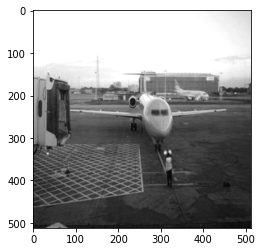

In [49]:
plt.imshow(q[0], cmap='gray')

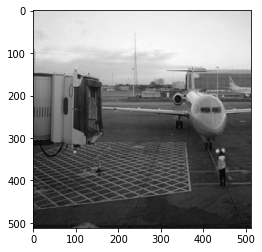

In [50]:
plt.imshow(k[0], cmap='gray')

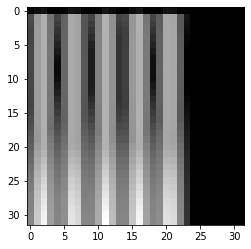

In [51]:
plt.imshow(mask_q.sum(dim=-1).reshape(32, 32), cmap='gray')

(True, True)

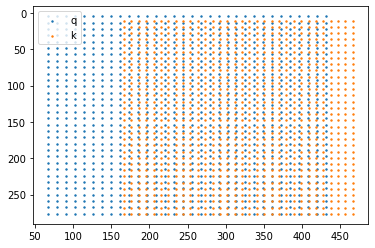

In [52]:
import numpy as np
size = 32
(i_q, j_q, h_q, w_q), hflip_q = loc_q
(i_k, j_k, h_k, w_k), hflip_k = loc_k
mesh_q = np.meshgrid(
    np.linspace(i_q+h_q/size/2, i_q+h_q-h_q/size/2, size), 
    np.linspace(j_q+w_q/size/2, j_q+w_q-w_q/size/2, size))
mesh_k = np.meshgrid(
    np.linspace(i_k+h_k/size/2, i_k+h_k-h_k/size/2, size), 
    np.linspace(j_k+w_k/size/2, j_k+w_k-w_k/size/2, size))
plt.scatter(mesh_q[1], mesh_q[0], s=2)
plt.scatter(mesh_k[1], mesh_k[0], s=2)
plt.gca().invert_yaxis()
plt.legend(['q', 'k'])
hflip_q, hflip_k

/root/.miniconda3/envs/ssl4dp/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


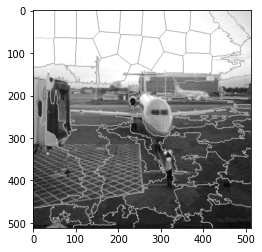

In [53]:
from skimage.segmentation import slic, mark_boundaries
img = einops.rearrange(q, 'c h w -> h w c')
supix = slic(img)
plt.imshow(mark_boundaries(img, supix)[:, :, 0], cmap='gray')